# Libraries

In [27]:
import calendar
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from IPython.core.display import display

from sklearn.cluster import KMeans

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_pinball_loss

import ipywidgets as widgets
from IPython.display import display, clear_output

# Data read in

In [28]:
file_path1 = "monthly_sales.xlsx"
file_path2 = "SKU Attributes Report.xlsx"

df_monthly_sales = pd.read_excel(file_path1)
df_monthly_sales = df_monthly_sales.sort_values(by='Intro Date')

df_sku_attributes = pd.read_excel(file_path2)

In [29]:
df_items = df_monthly_sales[['Item']].copy()

train_items = df_items.copy()
test_items = pd.DataFrame([0], columns=["Item"])

# Display the shapes of the resulting DataFrames to verify the split
print("Training items shape:", train_items.shape)
print("Training items shape:", test_items.shape)

Training items shape: (691, 1)
Training items shape: (1, 1)


# Dashboard

In [30]:
attribute_list = [
  'Category',
  'Subcategory Desc',
  'CommGroup2 Desc',
  'Intro Month',
  'Brand',
  'Price Range'
]

dropdowns = {}
selected_values = {} # Dictionary to store selected values

def on_dropdown_change(change):
    """Updates the selected_values dictionary when a dropdown value changes."""
    selected_values[change['owner'].description.replace('Select ', '').replace(':', '')] = change['new']

for attribute in attribute_list:
    if attribute in df_sku_attributes.columns:
        unique_values = df_sku_attributes[attribute].unique().tolist()
        # Sort the unique values and handle potential NaN values
        unique_values = sorted([str(x) for x in unique_values if pd.notna(x)])
        dropdowns[attribute] = widgets.Dropdown(
            options=unique_values,
            description=f'Select {attribute}:',
            disabled=False,
        )
        # Observe changes in the dropdown and call the update function
        dropdowns[attribute].observe(on_dropdown_change, names='value')
        display(dropdowns[attribute])

        # Initialize the selected_values dictionary with the default value
        selected_values[attribute] = dropdowns[attribute].value

    else:
        print(f"Attribute '{attribute}' not found in df_sku_attributes.")

#You can access the selected values using the selected_values dictionary, e.g., selected_values['Category']

Dropdown(description='Select Category:', options=('BACKP', 'BBAGS', 'BLKTW', 'COOL', 'DRINK', 'DUF', 'FOOD', '…

Dropdown(description='Select Subcategory Desc:', options=('Accents', 'Accessory', 'Active Hydration', 'All Occ…

Dropdown(description='Select CommGroup2 Desc:', options=('Accessory', 'All Purpose', 'Appliances', 'Aprons', '…

Dropdown(description='Select Intro Month:', options=('1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8',…

Dropdown(description='Select Brand:', options=('Ahead', 'American Tourister', 'Anker', 'Aviana', 'Cleer', 'Coo…

Dropdown(description='Select Price Range:', options=('$1-$5', '$10-$15', '$100+', '$15-$20', '$20-$25', '$25-$…

In [31]:
test_df_sku_attributes = pd.DataFrame(
[['0',
 selected_values['Category'],
 selected_values['Subcategory Desc'],
 selected_values['CommGroup2 Desc'],
 selected_values['Intro Month'],
 selected_values['Brand'],
 selected_values['Price Range']]],
 columns=['Item',
          'Category',
          'Subcategory Desc',
          'CommGroup2 Desc',
          'Intro Month',
          'Brand',
          'Price Range']
)

#SKU attributes

In [32]:
# Define your reusable attribute list once
attribute_list = [
  'Category',
  'Subcategory Desc',
  'CommGroup2 Desc',
  'Intro Month',
  ]

# Then reuse it to select columns
df_demand_profile_sku_attributes = df_sku_attributes[['Item'] + attribute_list]

test_df_demand_profile_sku_attributes = test_df_sku_attributes[['Item'] + attribute_list]

In [33]:
# Define your reusable attribute list once
attribute_list = [
  'Category',
  'Subcategory Desc',
  'CommGroup2 Desc',
  'Intro Month',
  'Brand',
  'Price Range'
  ]

# Then reuse it to select columns
df_total_demand_sku_attributes = df_sku_attributes[['Item'] + attribute_list]

test_df_total_demand_sku_attributes = test_df_sku_attributes[['Item'] + attribute_list]

#Sales distribution

In [34]:
# Select the columns to normalize
cols_to_normalize = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Calculate the sum of the selected columns for each row
df_monthly_sales['Total_Sales'] = df_monthly_sales[cols_to_normalize].sum(axis=1)

# Normalize the selected columns by dividing by the total sales for each row
for col in cols_to_normalize:
    df_monthly_sales[col] = df_monthly_sales[col] / df_monthly_sales['Total_Sales']

# Drop the 'Total_Sales' column as it is no longer needed
df_monthly_sales.drop(columns=['Total_Sales'], inplace=True)

# Display the head of the modified DataFrame to show the normalized columns
display(df_monthly_sales.head())

,Item,Intro Date,1,2,3,4,5,6,7,8,9,10,11,12
43,101036-001,2022-01-01,0.169947,0.091215,0.079693,0.008321,0.000320,0.000160,0.000960,0.018243,0.389662,0.210274,0.026884,0.004321
45,101037-001,2022-01-01,0.002447,0.004544,0.213911,0.301293,0.003495,0.000000,0.000000,0.000000,0.000000,0.034953,0.206222,0.233135
58,101184-920,2022-01-01,0.000000,0.000000,0.000000,0.141957,0.576353,0.001483,0.002595,0.000741,0.000371,0.001112,0.094144,0.181245
57,101184-237,2022-01-01,0.001968,0.004427,0.000246,0.089769,0.108706,0.291933,0.028283,0.034678,0.026316,0.198721,0.175848,0.039105
56,101183-920,2022-01-01,0.000000,0.000434,0.000000,0.000434,0.190187,0.000434,0.000000,0.000000,0.101172,0.223187,0.463309,0.020842


In [35]:
# Select the Item column and demand profile columns
columns_to_split = ['Item'] + [i for i in range(1, 13)]
df_split = df_monthly_sales[columns_to_split].dropna(subset=[i for i in range(1, 13)])

# Split the data into training and testing sets
train_df_demand_profiles = df_split[df_split['Item'].isin(train_items['Item'])].copy()
test_df_demand_profiles = pd.DataFrame(
    [['0', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
    columns=["Item", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
)

# Display the shapes of the resulting dataframes to verify the split
print("Training set shape:", train_df_demand_profiles.shape)
print("Test set shape:", test_df_demand_profiles.shape)

Training set shape: (688, 13)
Test set shape: (1, 13)


In [36]:
test_df_demand_profiles.head()

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1,2,3,4,5,6,7,8,9,10,11,12


In [37]:
# Create the two-column DataFrame
train_df_demand_profiles = pd.DataFrame({
    "Item": train_df_demand_profiles["Item"],
    "Cluster": train_df_demand_profiles.loc[:, 1:12].values.tolist()
})

print(train_df_demand_profiles.head())

          Item                                            Cluster
43  101036-001  [0.1699471915506481, 0.09121459433509362, 0.07...
45  101037-001  [0.002446696959105208, 0.004543865781195386, 0...
58  101184-920  [0.0, 0.0, 0.0, 0.1419570051890289, 0.57635285...
57  101184-237  [0.001967535661583866, 0.004426955238563699, 0...
56  101183-920  [0.0, 0.0004342162396873643, 0.0, 0.0004342162...


In [38]:
merged_df = pd.merge(train_df_demand_profiles, df_demand_profile_sku_attributes, on='Item', how='inner')

# Display the head of the merged DataFrame
display(merged_df.head())

,Item,Cluster,Category,Subcategory Desc,CommGroup2 Desc,Intro Month
0,101036-001,"[0.1699471915506481, 0.09121459433509362, 0.07...",TOTE,Event,Promo,1
1,101037-001,"[0.002446696959105208, 0.004543865781195386, 0...",TRAVL,Organization,Toiletry Bag,1
2,101184-920,"[0.0, 0.0, 0.0, 0.1419570051890289, 0.57635285...",OUTDR,Patio and Picnic,Cocktail Accessories,1
3,101184-237,"[0.001967535661583866, 0.004426955238563699, 0...",OUTDR,Patio and Picnic,Cocktail Accessories,1
4,101183-920,"[0.0, 0.0004342162396873643, 0.0, 0.0004342162...",TOTE,Everyday,All Purpose,1


In [39]:
merged_df.drop(columns=['Item'], inplace=True)

In [40]:
merged_df['Intro Month'] = merged_df['Intro Month'].astype('category')

In [41]:
#Separating target variable and other variables
y_train = merged_df['Cluster']#write your code here
x_train = merged_df.drop(columns={'Cluster'})#write your code here

In [42]:
#Creating dummy variables
#drop_first=True is used to avoid redundant variables
x_train = pd.get_dummies(x_train, drop_first=True)

In [43]:
y_train = np.vstack(merged_df['Cluster'].values)

In [44]:
# Choose the type of classifier
tree = RandomForestRegressor()

# Fit the best algorithm to the data
tree.fit(x_train, y_train)

RandomForestRegressor()

In [45]:
print(test_df_demand_profile_sku_attributes)

  Item Category Subcategory Desc CommGroup2 Desc Intro Month
0    0    BACKP          Accents       Accessory           1


In [46]:
# --- Clean and merge ---
test_df_demand_profiles['Item'] = test_df_demand_profiles['Item'].astype(str).str.strip().str.upper()
test_df_demand_profile_sku_attributes['Item'] = test_df_demand_profile_sku_attributes['Item'].astype(str).str.strip().str.upper()

merged_test_df = (
    pd.merge(
        test_df_demand_profiles,
        test_df_demand_profile_sku_attributes,
        on='Item',
        how='inner'
    )
    .drop(columns=['Item'])
)

# --- Convert categorical fields ---
merged_test_df['Intro Month'] = merged_test_df['Intro Month'].astype('category')

# --- Create dummies consistent with training ---
x_test = pd.get_dummies(merged_test_df, drop_first=False)

# Align test features to training features (adds missing = 0, drops extra)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

print("Prepared test data shape:", x_test.shape)

Prepared test data shape: (1, 180)


/tmp/ipython-input-907082297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_demand_profile_sku_attributes['Item'] = test_df_demand_profile_sku_attributes['Item'].astype(str).str.strip().str.upper()


In [47]:
merged_test_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,Category,Subcategory Desc,CommGroup2 Desc,Intro Month
0,1,2,3,4,5,6,7,8,9,10,11,12,BACKP,Accents,Accessory,1


In [48]:
non_zero_sum = (x_test != 0).sum().sum()
print(f"Sum of non-zero elements in x_test: {non_zero_sum}")

Sum of non-zero elements in x_test: 0


In [49]:
non_zero_sum = (x_train != 0).sum().sum()
print(f"Sum of non-zero elements in x_train: {non_zero_sum}")

Sum of non-zero elements in x_train: 2530


## Prediction

In [50]:
# Predict the clusters for the test data
y_pred = tree.predict(x_test)

# Display the predictions
display(y_pred[:10]) # Display first 10 predictions as an example

array([[0.01303445, 0.04330089, 0.07640756, 0.10706353, 0.10718043,
        0.0629534 , 0.06026389, 0.10684466, 0.09871701, 0.10575006,
        0.09117106, 0.12731306]])

In [51]:
# Define the demand profile columns
demand_profile_columns = [i for i in range(1, 13)]

In [52]:
# Create a new DataFrame with Item, predicted cluster, and actual demand profile
demand_profile_results_df = test_df_demand_profiles[['Item'] + demand_profile_columns].copy()
demand_profile_results_df['Predicted_Profile'] = y_pred.tolist()

# Display the head of the new DataFrame
display(demand_profile_results_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12,Predicted_Profile
0,0,1,2,3,4,5,6,7,8,9,10,11,12,"[0.01303445237718154, 0.04330088697744048, 0.0..."


In [53]:
df = demand_profile_results_df

# Expand
pred_df = pd.DataFrame(df["Predicted_Profile"].tolist(),
                       columns=[i for i in range(1, 13)],
                       index=df.index)

# Drop old month cols and Predicted_Profile
df = df.drop(columns=[i for i in range(1, 13)] + ["Predicted_Profile"], errors='ignore')

# Attach the new columns
df = df.join(pred_df)

demand_profile_results_df = df

display(demand_profile_results_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0.013034,0.043301,0.076408,0.107064,0.10718,0.062953,0.060264,0.106845,0.098717,0.10575,0.091171,0.127313


# First year sales

In [54]:
df_monthly_sales = pd.read_excel(file_path1)

In [55]:
df_monthly_sales['Total Sales'] = df_monthly_sales.iloc[:, 2:14].sum(axis=1)
df_monthly_sales = df_monthly_sales.drop(columns=[i for i in range(1, 13)])
display(df_monthly_sales.head())

,Item,Intro Date,Total Sales
0,100153-001,2024-01-01,3231
1,100154-001,2024-01-01,5959
2,100155-001,2024-01-01,4939
3,100176-777,2022-06-01,3531
4,100177-777,2022-06-01,4735


In [56]:
# Select the Item column and demand profile columns
columns_to_split = ['Item'] + ['Total Sales']
df_split = df_monthly_sales[columns_to_split]

# Split the data into training and testing sets
train_df_total_demand = df_split[df_split['Item'].isin(train_items['Item'])].copy()
test_df_total_demand = pd.DataFrame(
    [['0', 0]],
    columns=["Item", "Total Sales"]
)

# Display the shapes of the resulting dataframes to verify the split
print("Training set shape:", train_df_total_demand.shape)
print("Test set shape:", test_df_total_demand.shape)

Training set shape: (691, 2)
Test set shape: (1, 2)


## Prediction

In [57]:
merged_df = pd.merge(train_df_total_demand, df_total_demand_sku_attributes, on='Item', how='inner')

In [58]:
merged_df.drop(columns=['Item'], inplace=True)

In [59]:
merged_df['Intro Month'] = merged_df['Intro Month'].astype('category')

In [60]:
#Separating target variable and other variables
y_train = merged_df['Total Sales']#write your code here
x_train = merged_df.drop(columns={'Total Sales'})#write your code here

In [61]:
#Creating dummy variables
#drop_first=True is used to avoid redundant variables
x_train = pd.get_dummies(x_train, drop_first=True)

In [62]:
# Choose the type of regressor
q10 = GradientBoostingRegressor(loss="quantile", alpha=0.1, random_state=42)

# Fit the best algorithm to the data
q10.fit(x_train, y_train)


GradientBoostingRegressor(alpha=0.1, loss='quantile', random_state=42)

In [63]:
# Choose the type of regressor
q50 = GradientBoostingRegressor(loss="quantile", alpha=0.5, random_state=42)

# Fit the best algorithm to the data
q50.fit(x_train, y_train)


GradientBoostingRegressor(alpha=0.5, loss='quantile', random_state=42)

In [64]:
# Choose the type of regressor
q90 = GradientBoostingRegressor(loss="quantile", alpha=0.9, random_state=42)

# Fit the best algorithm to the data
q90.fit(x_train, y_train)

GradientBoostingRegressor(loss='quantile', random_state=42)

In [65]:
# --- Clean and merge ---
test_df_total_demand['Item'] = test_df_total_demand['Item'].astype(str).str.strip().str.upper()
df_total_demand_sku_attributes['Item'] = df_total_demand_sku_attributes['Item'].astype(str).str.strip().str.upper()

merged_test_df = pd.merge(
    test_df_total_demand,
    test_df_total_demand_sku_attributes,
    on='Item',
    how='inner'
).drop(columns=['Item'])

# --- Optional: reduce fragmentation from categorical columns ---
for col in merged_test_df.select_dtypes('object'):
    top_categories = merged_test_df[col].value_counts().nlargest(10).index
    merged_test_df[col] = np.where(merged_test_df[col].isin(top_categories), merged_test_df[col], 'Other')

# --- Create dummies consistent with training ---
x_test = pd.get_dummies(merged_test_df)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

print("Prepared test data shape:", x_test.shape)

Prepared test data shape: (1, 225)


/tmp/ipython-input-3366012073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_demand_sku_attributes['Item'] = df_total_demand_sku_attributes['Item'].astype(str).str.strip().str.upper()


In [66]:
# Predict the clusters for the test data
y_pred_q10 = q10.predict(x_test)
y_pred_q50 = q50.predict(x_test)
y_pred_q90 = q90.predict(x_test)


# Display the predictions
display(y_pred_q50[:10]) # Display first 10 predictions as an example

array([1902.91471079])

In [67]:
# Create a new DataFrame with Item, predicted cluster, and actual demand profile
total_demand_results_df = test_df_total_demand[['Item'] + ['Total Sales']].copy()
total_demand_results_df['Predicted demand (q10)'] = y_pred_q10
total_demand_results_df['Predicted demand (q50)'] = y_pred_q50
total_demand_results_df['Predicted demand (q90)'] = y_pred_q90

# Display the head of the new DataFrame
display(total_demand_results_df.head(50))

,Item,Total Sales,Predicted demand (q10),Predicted demand (q50),Predicted demand (q90)
0,0,0,595.18019,1902.914711,4965.101119


In [68]:
cols_to_drop = ['Total Sales', 'Residuals', 'Percent error']
existing_cols_to_drop = [col for col in cols_to_drop if col in total_demand_results_df.columns]
if existing_cols_to_drop:
    total_demand_results_df = total_demand_results_df.drop(columns=existing_cols_to_drop)
display(total_demand_results_df.head())

,Item,Predicted demand (q10),Predicted demand (q50),Predicted demand (q90)
0,0,595.18019,1902.914711,4965.101119


# Monthly sales forecast

## High

In [69]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q90)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q90)
high_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q90)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    high_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q90)']

# Display the head of the new DataFrame
display(high_monthly_sales_pred_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,0,64.717374,214.993282,379.371282,531.58124,532.161681,312.569999,299.216325,530.494521,490.139917,525.059754,452.673548,632.122197


## Medium

In [70]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q50)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q50)
medium_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q50)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    medium_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q50)']

# Display the head of the new DataFrame
display(medium_monthly_sales_pred_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,0,24.803451,82.397895,145.397078,203.732761,203.95522,119.794952,114.677049,203.316267,187.850043,201.23335,173.490757,242.265887


## Low

In [71]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q10)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q10)
low_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q10)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    low_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q10)']

# Display the head of the new DataFrame
display(low_monthly_sales_pred_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,0,7.757848,25.77183,45.476268,63.722091,63.79167,37.468617,35.867876,63.591823,58.754406,62.940342,54.263211,75.774209


## Visual

Number of items with complete data: 1


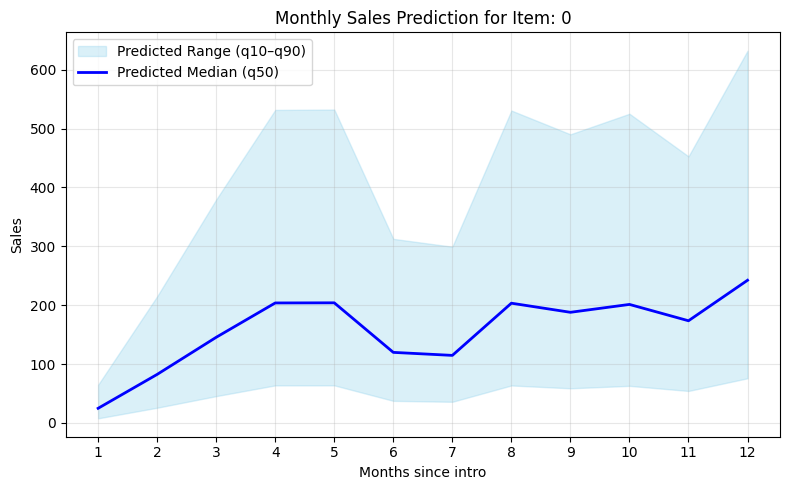

In [72]:
# Ensure required dataframes exist:
# test_df_total_demand, high_monthly_sales_pred_df, medium_monthly_sales_pred_df,
# low_monthly_sales_pred_df, df_monthly_sales

# --- 2️⃣ Prepare predicted monthly sales dataframes with proper suffixes ---
high_df = high_monthly_sales_pred_df.copy()
high_df.rename(columns={month: f'{month}_q90' for month in demand_profile_columns}, inplace=True)

medium_df = medium_monthly_sales_pred_df.copy()
medium_df.rename(columns={month: f'{month}_q50' for month in demand_profile_columns}, inplace=True)

low_df = low_monthly_sales_pred_df.copy()
low_df.rename(columns={month: f'{month}_q10' for month in demand_profile_columns}, inplace=True)

# --- 3️⃣ Merge all datasets on 'Item' ---
plot_data = test_df_total_demand[['Item']].copy()
plot_data = (
    plot_data
    .merge(high_df, on='Item', how='left')
    .merge(medium_df, on='Item', how='left')
    .merge(low_df, on='Item', how='left')
)

# --- 4️⃣ Define columns for plotting ---
months = list(range(1, 13))
high_cols = [f'{m}_q90' for m in months]
medium_cols = [f'{m}_q50' for m in months]
low_cols = [f'{m}_q10' for m in months]

# --- 5️⃣ Convert all relevant columns to numeric to prevent dtype issues ---
for col in high_cols + medium_cols + low_cols:
    plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')

# --- 6️⃣ Drop rows with missing or invalid data ---
all_plot_cols = high_cols + medium_cols + low_cols
plot_data_filtered = plot_data.dropna(subset=all_plot_cols).copy()

print(f"Number of items with complete data: {plot_data_filtered.shape[0]}")

# --- 7️⃣ Plot for each item with confidence interval ---
for _, item_data in plot_data_filtered.iterrows():
    item = item_data['Item']

    plt.figure(figsize=(8, 5))

    high = item_data[high_cols].astype(float).values
    medium = item_data[medium_cols].astype(float).values
    low = item_data[low_cols].astype(float).values

    # Confidence interval (shaded area)
    plt.fill_between(months, low, high, color='skyblue', alpha=0.3, label='Predicted Range (q10–q90)')

    # Median prediction line
    plt.plot(months, medium, color='blue', linewidth=2, label='Predicted Median (q50)')

    # Formatting
    plt.xlabel('Months since intro')
    plt.ylabel('Sales')
    plt.title(f'Monthly Sales Prediction for Item: {item}')
    plt.xticks(months)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
